In [1]:
import numpy as np
from os import path
from skimage import io
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import ipywidgets as widgets
from sklearn.metrics import accuracy_score

In [2]:
import A1.model, A2.model, B1.model, B2.model

2022-12-31 11:41:09.021179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Functions for loading data

In [3]:
LABELS = 'labels.csv'
DATASETS = 'Datasets'
IMGS = 'img'
TEST = '_test'

def load_data(folder, feature_col, file_col, load_image, augment=False):
    filenames, y = np.genfromtxt(
        path.join(DATASETS,folder,LABELS),
        usecols=(file_col,feature_col),
        dtype='U10,i8',
        unpack=True,
        skip_header=1,
        delimiter='\t'
    )
    y = np.maximum(y,0) # convert -1 label to 0
    imagedir = path.join(DATASETS,folder,IMGS)
    n = len(filenames)
    shape = load_image(path.join(imagedir,filenames[0])).shape # get first image to get shape
    X = np.empty((n*2 if augment else n, *shape), dtype=np.float32) # pre-define X, much more efficient than concatenating arrays
    for i in tqdm(range(n), desc=folder): # tqdm displays a nice loading bar
        X[i] = load_image(path.join(imagedir,filenames[i]))
    if augment:
        X[n:] = X[:n,:,::-1]  # copy images, but reverse left to right
        y = np.tile(y,2) # duplicate labels
    print(f'Loaded {X.nbytes:,} bytes')
    return X, y


Each task uses a different comibination of dataset, feature_col, file_col, and module:

In [4]:
TASKS = {'A1':('celeba',2,1,A1), 'A2':('celeba',3,1,A2), 'B1':('cartoon_set',2,3,B1),'B2':('cartoon_set',1,3,B2)}
task = widgets.Dropdown(options=TASKS, description='Task')
task

Dropdown(description='Task', options={'A1': ('celeba', 2, 1, <module 'A1' (namespace)>), 'A2': ('celeba', 3, 1…

In [5]:
dataset, feature_col, file_col, task_module = task.value
model = task_module.model

In [6]:
X, y = load_data(dataset, feature_col, file_col, model.load_image, augment=task.label.startswith('A'))

celeba:   0%|          | 0/5000 [00:00<?, ?it/s]

Loaded 252,000,000 bytes


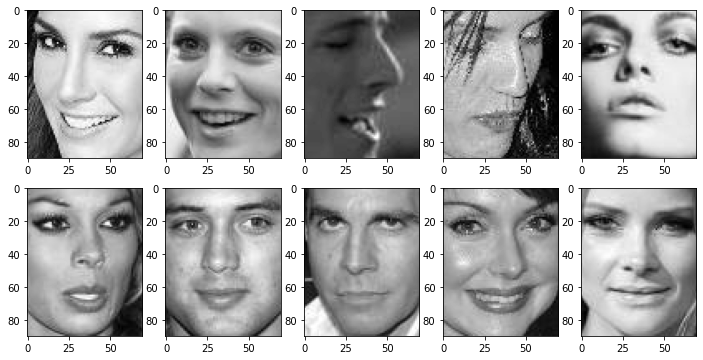

In [7]:
plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i], cmap='gray')
plt.show()

In [8]:
X_test, y_test = load_data(dataset+TEST, feature_col, file_col, model.load_image)

celeba_test:   0%|          | 0/1000 [00:00<?, ?it/s]

Loaded 25,200,000 bytes


In [9]:
model.fit(X, y, X_test, y_test)

2022-12-31 11:41:37.191262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
313/313 [==============================] - 16s 50ms/step - loss: 0.3858 - accuracy: 0.8272 - val_loss: 0.2524 - val_accuracy: 0.8980
Epoch 2/5
313/313 [==============================] - 14s 46ms/step - loss: 0.2602 - accuracy: 0.8868 - val_loss: 0.2398 - val_accuracy: 0.9020
Epoch 3/5
313/313 [==============================] - 16s 51ms/step - loss: 0.2357 - accuracy: 0.9001 - val_loss: 0.2304 - val_accuracy: 0.8940
Epoch 4/5
313/313 [==============================] - 15s 48ms/step - loss: 0.2305 - accuracy: 0.9026 - val_loss: 0.2366 - val_accuracy: 0.8940
Epoch 5/5
313/313 [==============================] - 16s 52ms/step - loss: 0.2260 - accuracy: 0.9055 - val_loss: 0.2436 - val_accuracy: 0.9120


In [10]:
y_pred = model.predict(X_test)

32/32 [==============================] - 1s 16ms/step


In [11]:
print("Accuracy on test data:", accuracy_score(y_test,y_pred))

Accuracy on test data: 0.912


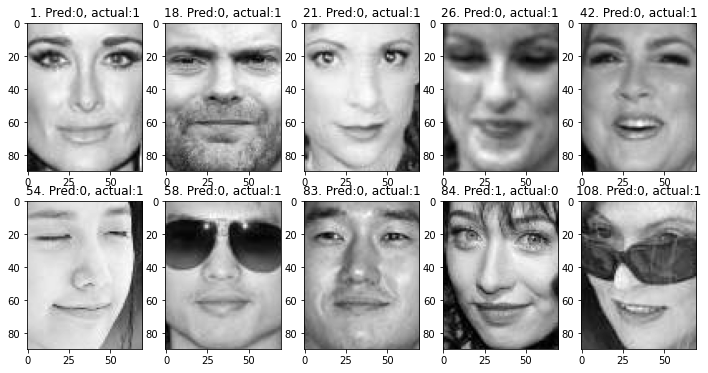

In [12]:
wrong, = np.nonzero(y_test!=y_pred)
plt.figure(figsize=(12,6))
for w,i in enumerate(wrong[:10]): # show first 10 that are wrong
    plt.subplot(2, 5, w+1)
    plt.title(str(i)+'. Pred:'+str(y_pred[i])+', actual:'+str(y_test[i]))
    plt.imshow(X_test[i], cmap='gray')
plt.show()

In [13]:
print("Accuracy on trained data:", accuracy_score(y,model.predict(X)))

313/313 [==============================] - 5s 17ms/step
Accuracy on trained data: 0.9058
